# Initialize Folders

In [87]:
from __future__ import print_function
from imutils import paths
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras import backend as keras
from keras.layers.advanced_activations import LeakyReLU, PReLU


#import skimage.io as io
#import skimage.transform as trans

#K.set_image_data_format("channels_last")

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
root_dir = './data'
training_data_dir = os.path.join(root_dir, 'train/images')
training_data_mask_dir = os.path.join(root_dir, 'train/masks')

val_data_dir = os.path.join(root_dir, 'val/images')
val_data_pred_dir = os.path.join(root_dir, 'val/predict')
val_data_mask_dir = os.path.join(root_dir, 'val/masks')

test_data_dir = os.path.join(root_dir, 'test/images')
test_data_pred_dir = os.path.join(root_dir, 'test/predict')
test_data_mask_dir = os.path.join(root_dir, 'test/masks')

model_localtion = "attention_unet_lesion.hdf5"
result_file = "attention_unet_test_result.csv"
img_rows = 256
img_cols = 256

# Define Loss function

In [89]:
def jaccard_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def jaccard_coef_loss(y_true, y_pred):
    j = -jaccard_coef(y_true, y_pred)
    return j

In [90]:
# DO NOT USE
def normalizeData_rgb(img,mask):
    for i in range(3):
        mean = np.mean(img[:,:,i])  # mean for data centering
        std = np.std(img[:,:,i])  # std for data normalization
        img[:,:,i] -= mean
        img[:,:,i] /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [91]:
def normalizeData(img,mask):
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [92]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        #img,mask = normalizeData_rgb(img,mask)
        img, mask = normalizeData(img, mask)
        yield (img,mask)

In [93]:
def validationGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        #img,mask = normalizeData_rgb(img,mask)
        img, mask = normalizeData(img, mask)
        yield (img,mask)

In [94]:
def BiggerLeakyUnetModel():
    inputs = Input((img_rows, img_cols,3))
    conv1 = Conv2D(32, (3, 3), padding="same")(inputs)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same")(acti1)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(acti1)

    conv2 = Conv2D(64, (3, 3), padding="same")(pool1)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same")(acti2)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(acti2)

    conv3 = Conv2D(128, (3, 3), padding="same")(pool2)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same")(acti3)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(acti3)

    conv4 = Conv2D(256, (3, 3), padding="same")(pool3)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same")(acti4)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(acti4)

    conv5 = Conv2D(512, (3, 3), padding="same")(pool4)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same")(acti5)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(acti5)

    conv6 = Conv2D(1024, (3, 3), padding="same")(pool5)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    conv6 = Conv2D(1024, (3, 3), padding="same")(acti6)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(acti6)
    
    conv7 = Conv2D(2048, (3, 3), padding="same")(pool6)
    acti7 = LeakyReLU(alpha=0.001)(conv7)
    conv7 = Conv2D(2048, (3, 3), padding="same")(acti7)
    acti7 = LeakyReLU(alpha=0.001)(conv7)

    right_up6 = concatenate([UpSampling2D(size=(2, 2))(acti7), acti6], axis=3)
    right_conv6 = Conv2D(512, (3, 3), padding="same")(right_up6)
    right_acti6 = LeakyReLU(alpha=0.001)(right_conv6)
    right_conv6 = Conv2D(512, (3, 3), padding="same")(right_acti6)
    right_acti6 = LeakyReLU(alpha=0.001)(right_conv6)

    right_up5 = concatenate([UpSampling2D(size=(2, 2))(right_acti6), acti5], axis=3)
    right_conv5 = Conv2D(512, (3, 3), padding="same")(right_up5)
    right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)
    right_conv5 = Conv2D(512, (3, 3), padding="same")(right_acti5)
    right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)

    right_up4 = concatenate([UpSampling2D(size=(2, 2))(right_acti5), acti4], axis=3)
    right_conv4 = Conv2D(256, (3, 3), padding="same")(right_up4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)
    right_conv4 = Conv2D(256, (3, 3), padding="same")(right_acti4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)

    right_up3 = concatenate([UpSampling2D(size=(2, 2))(right_acti4), acti3], axis=3)
    right_conv3 = Conv2D(128, (3, 3), padding="same")(right_up3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)
    right_conv3 = Conv2D(128, (3, 3), padding="same")(right_acti3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)

    right_up2 = concatenate([UpSampling2D(size=(2, 2))(right_acti3), acti2], axis=3)
    right_conv2 = Conv2D(64, (3, 3), padding="same")(right_up2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)
    right_conv2 = Conv2D(64, (3, 3), padding="same")(right_acti2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)

    right_up1 = concatenate([UpSampling2D(size=(2, 2))(right_acti2), acti1], axis=3)
    right_conv1 = Conv2D(32, (3, 3), padding="same")(right_up1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)
    right_conv1 = Conv2D(32, (3, 3), padding="same")(right_acti1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)

    output = Conv2D(1, (1, 1), activation='sigmoid')(right_acti1)

    model = Model(input=inputs, output=output)

    model.compile(optimizer=Adam(lr=5e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

# Define UNet Network

In [95]:
def conv_block(prevlayer, ch_out, prefix, strides=(1, 1)):
    conv = Conv2D(ch_out, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "1_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "1_bn")(conv)
    conv = LeakyReLU(alpha=0.001, name=prefix + "1_activation")(conv)
    conv = Conv2D(ch_out, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "2_conv")(conv)
    conv = BatchNormalization(name=prefix + "1_bn")(conv)
    conv = LeakyReLU(alpha=0.001, name=prefix + "1_activation")(conv)
    return conv

def double_block(prevlayer, filters, prefix, strides=(1, 1)):
    layer1 = conv_block(prevlayer, filters, prefix+"1", strides)
    layer2 = conv_block(layer1   , filters, prefix+"2", strides)
    return layer2

def up_sampling_block(up_sampling_layer, left_skip_layer, filters, prefix, strides = (1,1)):
    up_layer = Concatenate([UpSampling2D(size=(2, 2))(up_sampling_layer), left_skip_layer], axis=3)
    double_block_layer = double_block(up_layer, filters, prefix, strides)
    return double_block_layer

def attention_block(direct_layer, left_skip_layer, filters, prefix, kernel=(1,1), strides=(1,1)):
    conv_skip = Conv2D(filters, kernel, kernel_initializer="he_normal", strides=strides, name=prefix + "skip_conv")(left_skip_layer)
    # TO Try: Add batch norm
    conv_direct = Conv2D(filters, kernel, kernel_initializer="he_normal", strides=strides, name=prefix + "direct_conv")(direct_layer)
    # TO Try: Add batch norm
    psi = add([conv_skip, conv_direct])
    psi = LeakyReLU(alpha=0.001, name=prefix + "_relu")(psi)
    psi = Conv2D(1, kernel, kernel_initializer="glorot_normal", activation="sigmoid", strides=strides, name=prefix + "_att")(psi)
    return multiply([left_skip_layer, psi])
    
    


In [96]:
def AttentionUnetModel():
    # 3 - RGB 
    # Based on BiggerLeakyUnetModel
    inputs = Input((img_rows, img_cols,3))
    conv1 = Conv2D(32, (3, 3), padding="same")(inputs)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same")(acti1)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(acti1)

    conv2 = Conv2D(64, (3, 3), padding="same")(pool1)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same")(acti2)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(acti2)

    conv3 = Conv2D(128, (3, 3), padding="same")(pool2)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same")(acti3)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(acti3)

    conv4 = Conv2D(256, (3, 3), padding="same")(pool3)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same")(acti4)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(acti4)

    conv5 = Conv2D(512, (3, 3), padding="same")(pool4)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same")(acti5)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(acti5)

    conv6 = Conv2D(1024, (3, 3), padding="same")(pool5)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    conv6 = Conv2D(1024, (3, 3), padding="same")(acti6)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(acti6)
    
    conv7 = Conv2D(2048, (3, 3), padding="same")(pool6)
    acti7 = LeakyReLU(alpha=0.001)(conv7)
    conv7 = Conv2D(2048, (3, 3), padding="same")(acti7)
    acti7 = LeakyReLU(alpha=0.001)(conv7)

    right_acti7 = UpSampling2D(size=(2, 2))(acti7)
    right_att6 = attention_block(right_acti7, acti6, 1024, "att6")
    right_up6 = concatenate([right_att6, right_acti7], axis=3)
    right_conv6 = Conv2D(1024, (3, 3), padding="same")(right_up6)
    right_acti6 = LeakyReLU(alpha=0.001)(right_conv6)
    right_conv6 = Conv2D(1024, (3, 3), padding="same")(right_acti6)
    right_acti6 = LeakyReLU(alpha=0.001)(right_conv6)

    right_acti6 = UpSampling2D(size=(2, 2))(right_acti6)
    right_att5 = attention_block(right_acti6, acti5, 512, "att5")
    right_up5 = concatenate([right_att5, right_acti6], axis=3)
    right_conv5 = Conv2D(512, (3, 3), padding="same")(right_up5)
    right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)
    right_conv5 = Conv2D(512, (3, 3), padding="same")(right_acti5)
    right_acti5 = LeakyReLU(alpha=0.001)(right_conv5)

    right_acti5 = UpSampling2D(size=(2, 2))(right_acti5)
    right_att4 = attention_block(right_acti5, acti4, 256, "att4")
    right_up4 = concatenate([right_att4, right_acti5], axis=3)
    right_conv4 = Conv2D(256, (3, 3), padding="same")(right_up4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)
    right_conv4 = Conv2D(256, (3, 3), padding="same")(right_acti4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)

    right_acti4 = UpSampling2D(size=(2, 2))(right_acti4)
    right_att3 = attention_block(right_acti4, acti3, 128, "att3")
    right_up3 = concatenate([right_att3, right_acti4], axis=3)
    right_conv3 = Conv2D(128, (3, 3), padding="same")(right_up3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)
    right_conv3 = Conv2D(128, (3, 3), padding="same")(right_acti3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)

    right_acti3 = UpSampling2D(size=(2, 2))(right_acti3)
    right_att2 = attention_block(right_acti3, acti2, 64, "att2")
    right_up2 = concatenate([right_att2, right_acti3], axis=3)
    right_conv2 = Conv2D(64, (3, 3), padding="same")(right_up2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)
    right_conv2 = Conv2D(64, (3, 3), padding="same")(right_acti2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)

    right_acti2 = UpSampling2D(size=(2, 2))(right_acti2)
    right_att1 = attention_block(right_acti2, acti1, 32, "att1")
    right_up1 = concatenate([right_att1, right_acti2], axis=3)
    right_conv1 = Conv2D(32, (3, 3), padding="same")(right_up1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)
    right_conv1 = Conv2D(32, (3, 3), padding="same")(right_acti1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)

    output = Conv2D(1, (1, 1), activation='sigmoid')(right_acti1)

    model = Model(input=inputs, output=output)

    model.compile(optimizer=Adam(lr=5e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

In [97]:
#Training data generation
data_gen_args = dict(
#    samplewise_center = True,
#    samplewise_std_normalization = True,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

#Validation data generation
data_val_gen_args = dict(
    #samplewise_center = True,
    #samplewise_std_normalization = True
    )

#Create UNet Model
#model = FullUnetModel()
#model = UnetModel()
model = AttentionUnetModel()
model.summary()
#model = BiggerLeakyUnetModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 256, 256, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_171 (LeakyReLU)     (None, 256, 256, 32) 0           conv2d_177[0][0]                 
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 256, 256, 32) 9248        leaky_re_lu_171[0][0]            
__________________________________________________________________________________________________
leaky_re_l

/udir/gwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [98]:
#Setup generator
batch_size = 2

myGene = trainGenerator(batch_size,'data/train','images','masks',data_gen_args)
myValGene = validationGenerator(batch_size,'data/val','images','masks',data_val_gen_args)

#Setup Checkpoint to only capture best estimate
model_checkpoint = ModelCheckpoint(model_localtion, monitor='loss',verbose=1, save_best_only=True)

#Enable tensorboard
tensorBoard = TensorBoard(
    log_dir='./logs', 
    histogram_freq=0, 
    batch_size=batch_size, 
    write_graph=True, 
    write_grads=False, 
    write_images=True, 
    embeddings_freq=0)


In [99]:

#Train
history = model.fit_generator(
    myGene,
    steps_per_epoch = 1000, 
    #epochs=100,
    epochs = 100,
    callbacks=[model_checkpoint,tensorBoard],
    validation_data=myValGene,
    validation_steps=300)

Epoch 1/100
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
1000/1000 [==============================] - 595s 595ms/step - loss: -0.5839 - jaccard_coef: 0.5839 - val_loss: -0.7071 - val_jaccard_coef: 0.7071

Epoch 00001: loss improved from inf to -0.58420, saving model to attention_unet_lesion.hdf5
Epoch 2/100
1000/1000 [==============================] - 566s 566ms/step - loss: -0.7036 - jaccard_coef: 0.7036 - val_loss: -0.7191 - val_jaccard_coef: 0.7191

Epoch 00002: loss improved from -0.58420 to -0.70349, saving model to attention_unet_lesion.hdf5
Epoch 3/100
1000/1000 [==============================] - 600s 600ms/step - loss: -0.7198 - jaccard_coef: 0.7198 - val_loss: -0.7222 - val_jaccard_coef: 0.7222

Epoch 00003: loss improved from -0.70349 to -0.71979, saving model to attention_unet_lesion.hdf5
Epoch 4/100
1000/1000 [==============================] - 574s 574ms/


Epoch 00035: loss did not improve from -0.79315
Epoch 36/100
1000/1000 [==============================] - 581s 581ms/step - loss: -0.7857 - jaccard_coef: 0.7857 - val_loss: -0.7766 - val_jaccard_coef: 0.7766

Epoch 00036: loss did not improve from -0.79315
Epoch 37/100
1000/1000 [==============================] - 578s 578ms/step - loss: -0.7893 - jaccard_coef: 0.7893 - val_loss: -0.7942 - val_jaccard_coef: 0.7942

Epoch 00037: loss did not improve from -0.79315
Epoch 38/100
1000/1000 [==============================] - 572s 572ms/step - loss: -0.7855 - jaccard_coef: 0.7855 - val_loss: -0.7310 - val_jaccard_coef: 0.7310

Epoch 00038: loss did not improve from -0.79315
Epoch 39/100
1000/1000 [==============================] - 582s 582ms/step - loss: -0.7882 - jaccard_coef: 0.7882 - val_loss: -0.7971 - val_jaccard_coef: 0.7971

Epoch 00039: loss did not improve from -0.79315
Epoch 40/100
1000/1000 [==============================] - 574s 574ms/step - loss: -0.7946 - jaccard_coef: 0.7946 - 

1000/1000 [==============================] - 576s 576ms/step - loss: -0.8071 - jaccard_coef: 0.8071 - val_loss: -0.8110 - val_jaccard_coef: 0.8110

Epoch 00073: loss did not improve from -0.80976
Epoch 74/100
1000/1000 [==============================] - 584s 584ms/step - loss: -0.8040 - jaccard_coef: 0.8040 - val_loss: -0.7910 - val_jaccard_coef: 0.7910

Epoch 00074: loss did not improve from -0.80976
Epoch 75/100
1000/1000 [==============================] - 580s 580ms/step - loss: -0.7997 - jaccard_coef: 0.7997 - val_loss: -0.7944 - val_jaccard_coef: 0.7944

Epoch 00075: loss did not improve from -0.80976
Epoch 76/100
1000/1000 [==============================] - 580s 580ms/step - loss: -0.7966 - jaccard_coef: 0.7966 - val_loss: -0.7831 - val_jaccard_coef: 0.7831

Epoch 00076: loss did not improve from -0.80976
Epoch 77/100
1000/1000 [==============================] - 582s 582ms/step - loss: -0.8080 - jaccard_coef: 0.8080 - val_loss: -0.8062 - val_jaccard_coef: 0.8062

Epoch 00077: los

In [100]:
#Continue traing
#Use initial_epoch 
'''
history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 1000, 
    epochs=100,
    callbacks=[model_checkpoint,tensorBoard], 
    initial_epoch = 125,
    validation_data=myValGene,
    validation_steps=200)
'''

'\nhistory2 = model.fit_generator(\n    myGene,\n    steps_per_epoch = 1000, \n    epochs=100,\n    callbacks=[model_checkpoint,tensorBoard], \n    initial_epoch = 125,\n    validation_data=myValGene,\n    validation_steps=200)\n'

[-0.7070843739581227, -0.7190667214198582, -0.7222494733751517, -0.7574803715257692, -0.7301398658244956, -0.7474031512297453, -0.737172081618006, -0.7647772939853955, -0.7796676511159524, -0.7596282971920274, -0.7670983085548738, -0.7714974457811633, -0.7632791900315811, -0.7849527529887047, -0.7567341528422447, -0.7786021017607843, -0.7807302976987994, -0.7811803551568014, -0.7730258728481693, -0.7858560147717046, -0.7699726932808035, -0.7856583144882685, -0.7761399410105309, -0.78211986282234, -0.7933064213081672, -0.787510887909693, -0.7751135435794948, -0.7876365192744489, -0.7888207388839658, -0.7808833458586806, -0.795417237125076, -0.7874720216493972, -0.7712001843147454, -0.7705354754236187, -0.798367138174619, -0.7766187042744211, -0.794171770596146, -0.7310235564144506, -0.7970542576924017, -0.7856846213689034, -0.798199270822369, -0.7702140977764766, -0.7944642457370965, -0.7909816143807267, -0.7946321860030418, -0.7861715174688144, -0.7968824321220633, -0.7917582532002253,

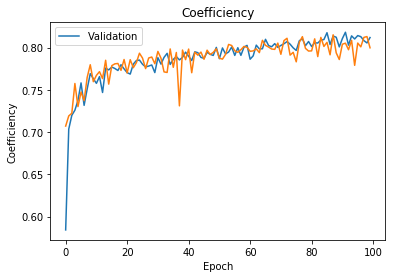

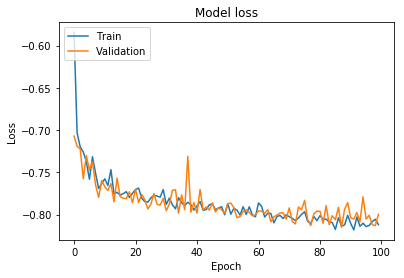

In [101]:
# Plot training & validation accuracy values
print (history.history['val_loss'])
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['val_jaccard_coef'])
plt.title('Coefficiency')
plt.ylabel('Coefficiency')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
file_names = next(os.walk(test_data_dir))[2]

model = AttentionUnetModel()
model.load_weights(model_localtion)

/udir/gwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [28]:
help(model)

Help on Model in module keras.engine.training object:

class Model(keras.engine.network.Network)
 |  Model(*args, **kwargs)
 |  
 |  The `Model` class adds training & evaluation routines to a `Network`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.network.Network
 |      keras.engine.base_layer.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function.
 |              See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary or a list of losses

/udir/gwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


ISIC_0012852.jpg
ISIC_0010570.jpg
ISIC_0014735.jpg
ISIC_0010461.jpg
ISIC_0012187.jpg
ISIC_0013663.jpg
ISIC_0009504.jpg
ISIC_0000384.jpg
ISIC_0010587.jpg
ISIC_0014308.jpg
ISIC_0012257.jpg
ISIC_0013670.jpg
ISIC_0015980.jpg
ISIC_0010089.jpg
ISIC_0006776.jpg
ISIC_0010010.jpg
ISIC_0015153.jpg
ISIC_0015955.jpg
ISIC_0011292.jpg
ISIC_0013048.jpg
ISIC_0009910.jpg
ISIC_0016051.jpg
ISIC_0014395.jpg
ISIC_0011317.jpg
ISIC_0014635.jpg
ISIC_0006350.jpg
ISIC_0011347.jpg
ISIC_0013908.jpg
ISIC_0014625.jpg
ISIC_0000457.jpg
ISIC_0013982.jpg
ISIC_0013493.jpg
ISIC_0010047.jpg
ISIC_0013736.jpg
ISIC_0000524.jpg
ISIC_0011327.jpg
ISIC_0015276.jpg
ISIC_0013925.jpg
ISIC_0014957.jpg
ISIC_0015526.jpg
ISIC_0013738.jpg
ISIC_0000494.jpg
ISIC_0000488.jpg
ISIC_0012836.jpg
ISIC_0015440.jpg
ISIC_0014961.jpg
ISIC_0001247.jpg
ISIC_0000537.jpg
ISIC_0000326.jpg
ISIC_0012901.jpg
ISIC_0014422.jpg
ISIC_0000208.jpg
ISIC_0000105.jpg
ISIC_0012285.jpg
ISIC_0015997.jpg
ISIC_0014863.jpg
ISIC_0013226.jpg
ISIC_0010028.jpg
ISIC_0000037.j

ISIC_0008116.jpg
ISIC_0013082.jpg
ISIC_0014049.jpg
ISIC_0012155.jpg
ISIC_0010848.jpg
ISIC_0013580.jpg
ISIC_0015133.jpg
ISIC_0012891.jpg
ISIC_0013094.jpg
ISIC_0011202.jpg
ISIC_0013075.jpg
ISIC_0015566.jpg
ISIC_0000203.jpg
ISIC_0016022.jpg
ISIC_0012690.jpg
ISIC_0014558.jpg
ISIC_0013488.jpg
ISIC_0013799.jpg
ISIC_0000249.jpg
ISIC_0014110.jpg
ISIC_0013216.jpg
ISIC_0014726.jpg
ISIC_0015455.jpg
ISIC_0014171.jpg
ISIC_0010568.jpg
ISIC_0015040.jpg
ISIC_0013865.jpg
ISIC_0015118.jpg
ISIC_0015157.jpg
ISIC_0014740.jpg
ISIC_0011324.jpg
ISIC_0010592.jpg
ISIC_0014696.jpg
ISIC_0010480.jpg
ISIC_0012118.jpg
ISIC_0012379.jpg
ISIC_0012228.jpg


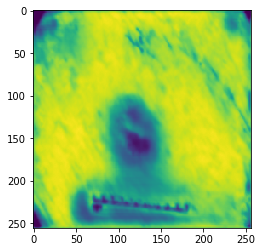

In [32]:
file_names = next(os.walk(test_data_dir))[2]

model = AttentionUnetModel()
model.load_weights(model_localtion)


for file in file_names:
    print(file)
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    img = img_to_array(grey_img)
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization
    img -= mean
    img /= std
    img = np.reshape(img,(1,)+img.shape)
    results = model.predict(img)

    result_img = array_to_img(results[0] * 255 )
    plt.imshow(result_img)
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_131 (LeakyReLU)     (None, 256, 256, 32) 0           conv2d_136[0][0]                 
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 256, 256, 32) 9248        leaky_re_lu_131[0][0]            
__________________________________________________________________________________________________
leaky_re_l

In [102]:
def predictTestSet(model_location):
    model.load_weights(model_location)

    file_names = next(os.walk(test_data_dir))[2]
    scores = []
    for file in file_names:
        print (file)
        grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
        mask_img = load_img(os.path.join(test_data_mask_dir,file.split('.')[0]+"_segmentation.png"), 
                            target_size=(img_rows, img_cols), grayscale=True)
        img = img_to_array(grey_img)
        img_mask = img_to_array(mask_img)

        #Preprocess image mask
        #img_mask = img_mask /255
        #img_mask[img_mask > 0.5] = 1
        #img_mask[img_mask <= 0.5] = 0
        #Preprocess images
        #mean = np.mean(img)  # mean for data centering
        #std = np.std(img)  # std for data normalization
        #img -= mean
        #img /= std
        #img, img_mask= normalizeData_rgb(img, img_mask)
        img, img_mask = normalizeData(img, img_mask)
        img = np.reshape(img,(1,)+img.shape)

        pred = model.predict([img])
        sess = tf.Session()
        score = sess.run(jaccard_coef(img_mask, pred))
        print("{} -- jaccard index: {}".format(file,score))
        scores.append([file,score])

        result_img = array_to_img(pred[0] * 255 )
        result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

    with open(result_file, 'w') as f:
        f.write("filename, jaccard_index\n")
        for i in range(len(scores)):
        #print(scores[i])
            f.write("{},{}\n".format(scores[i][0], scores[i][1]))

In [103]:
predictTestSet(model_localtion)

ISIC_0015208.jpg
ISIC_0015208.jpg -- jaccard index: 0.9436652660369873
ISIC_0014110.jpg
ISIC_0014110.jpg -- jaccard index: 0.9409053325653076
ISIC_0015207.jpg
ISIC_0015207.jpg -- jaccard index: 0.722905695438385
ISIC_0009951.jpg
ISIC_0009951.jpg -- jaccard index: 0.6307893395423889
ISIC_0000365.jpg
ISIC_0000365.jpg -- jaccard index: 0.8906716704368591
ISIC_0014092.jpg
ISIC_0014092.jpg -- jaccard index: 0.797973096370697
ISIC_0014855.jpg
ISIC_0014855.jpg -- jaccard index: 0.8642931580543518
ISIC_0011166.jpg
ISIC_0011166.jpg -- jaccard index: 0.8667610883712769
ISIC_0010599.jpg
ISIC_0010599.jpg -- jaccard index: 0.9627455472946167
ISIC_0000484.jpg
ISIC_0000484.jpg -- jaccard index: 0.8400183916091919
ISIC_0010474.jpg
ISIC_0010474.jpg -- jaccard index: 0.9335598945617676
ISIC_0012706.jpg
ISIC_0012706.jpg -- jaccard index: 0.2535800337791443
ISIC_0010067.jpg
ISIC_0010067.jpg -- jaccard index: 0.7856256365776062
ISIC_0015229.jpg
ISIC_0015229.jpg -- jaccard index: 0.8272416591644287
ISIC_001

ISIC_0000215.jpg -- jaccard index: 0.8718861937522888
ISIC_0013794.jpg
ISIC_0013794.jpg -- jaccard index: 0.9334277510643005
ISIC_0013001.jpg
ISIC_0013001.jpg -- jaccard index: 0.6950810551643372
ISIC_0014956.jpg
ISIC_0014956.jpg -- jaccard index: 0.8219770193099976
ISIC_0015044.jpg
ISIC_0015044.jpg -- jaccard index: 0.9391632676124573
ISIC_0000048.jpg
ISIC_0000048.jpg -- jaccard index: 0.9145694971084595
ISIC_0015279.jpg
ISIC_0015279.jpg -- jaccard index: 0.7088068127632141
ISIC_0009902.jpg
ISIC_0009902.jpg -- jaccard index: 0.805670976638794
ISIC_0014775.jpg
ISIC_0014775.jpg -- jaccard index: 0.7447139024734497
ISIC_0014546.jpg
ISIC_0014546.jpg -- jaccard index: 0.8029857873916626
ISIC_0000036.jpg
ISIC_0000036.jpg -- jaccard index: 0.8227514624595642
ISIC_0014787.jpg
ISIC_0014787.jpg -- jaccard index: 0.7837896347045898
ISIC_0014985.jpg
ISIC_0014985.jpg -- jaccard index: 0.4359811544418335
ISIC_0013311.jpg
ISIC_0013311.jpg -- jaccard index: 0.8927128314971924
ISIC_0012342.jpg
ISIC_00

ISIC_0012661.jpg -- jaccard index: 0.7268364429473877
ISIC_0009967.jpg
ISIC_0009967.jpg -- jaccard index: 0.954157292842865
ISIC_0000095.jpg
ISIC_0000095.jpg -- jaccard index: 0.9075051546096802
ISIC_0003346.jpg
ISIC_0003346.jpg -- jaccard index: 0.9261913299560547
ISIC_0012521.jpg
ISIC_0012521.jpg -- jaccard index: 0.9329481720924377
ISIC_0014150.jpg
ISIC_0014150.jpg -- jaccard index: 0.9435707330703735
ISIC_0014089.jpg
ISIC_0014089.jpg -- jaccard index: 0.895251989364624
ISIC_0010847.jpg
ISIC_0010847.jpg -- jaccard index: 0.6308495998382568
ISIC_0014794.jpg
ISIC_0014794.jpg -- jaccard index: 0.9643744230270386
ISIC_0013815.jpg
ISIC_0013815.jpg -- jaccard index: 0.7556180357933044
ISIC_0015241.jpg
ISIC_0015241.jpg -- jaccard index: 0.9281194806098938
ISIC_0015949.jpg
ISIC_0015949.jpg -- jaccard index: 0.9440951347351074
ISIC_0014486.jpg
ISIC_0014486.jpg -- jaccard index: 0.7388418316841125
ISIC_0000525.jpg
ISIC_0000525.jpg -- jaccard index: 0.9317834973335266
ISIC_0015211.jpg
ISIC_001

ISIC_0014848.jpg -- jaccard index: 0.9522831439971924
ISIC_0012108.jpg
ISIC_0012108.jpg -- jaccard index: 0.8834151029586792
ISIC_0013695.jpg
ISIC_0013695.jpg -- jaccard index: 0.8377685546875
ISIC_0000324.jpg
ISIC_0000324.jpg -- jaccard index: 0.8481561541557312
ISIC_0003728.jpg
ISIC_0003728.jpg -- jaccard index: 0.08527374267578125
ISIC_0015153.jpg
ISIC_0015153.jpg -- jaccard index: 0.9306396842002869
ISIC_0011219.jpg
ISIC_0011219.jpg -- jaccard index: 0.9616196751594543
ISIC_0013112.jpg
ISIC_0013112.jpg -- jaccard index: 0.8011664748191833
ISIC_0015980.jpg
ISIC_0015980.jpg -- jaccard index: 0.8961063027381897
ISIC_0012878.jpg
ISIC_0012878.jpg -- jaccard index: 0.9295852184295654
ISIC_0010444.jpg
ISIC_0010444.jpg -- jaccard index: 0.7910277843475342
ISIC_0009898.jpg
ISIC_0009898.jpg -- jaccard index: 0.7682247161865234
ISIC_0012260.jpg
ISIC_0012260.jpg -- jaccard index: 0.877377986907959
ISIC_0000387.jpg
ISIC_0000387.jpg -- jaccard index: 0.8997378349304199
ISIC_0012464.jpg
ISIC_0012

ISIC_0012201.jpg -- jaccard index: 0.9574273824691772
ISIC_0013690.jpg
ISIC_0013690.jpg -- jaccard index: 0.6082183122634888
ISIC_0013972.jpg
ISIC_0013972.jpg -- jaccard index: 0.4598482847213745
ISIC_0006021.jpg
ISIC_0006021.jpg -- jaccard index: 0.8173379302024841
ISIC_0012164.jpg
ISIC_0012164.jpg -- jaccard index: 0.857143223285675
ISIC_0015212.jpg
ISIC_0015212.jpg -- jaccard index: 0.9537661075592041
ISIC_0014726.jpg
ISIC_0014726.jpg -- jaccard index: 0.8520596027374268
ISIC_0000313.jpg
ISIC_0000313.jpg -- jaccard index: 0.8853556513786316
ISIC_0000370.jpg
ISIC_0000370.jpg -- jaccard index: 0.9230806827545166
ISIC_0015034.jpg
ISIC_0015034.jpg -- jaccard index: 0.9692023396492004
ISIC_0001191.jpg
ISIC_0001191.jpg -- jaccard index: 0.831539511680603
ISIC_0011202.jpg
ISIC_0011202.jpg -- jaccard index: 0.8002237677574158
ISIC_0013109.jpg
ISIC_0013109.jpg -- jaccard index: 0.8790902495384216
ISIC_0000247.jpg
ISIC_0000247.jpg -- jaccard index: 0.7548422813415527
ISIC_0010321.jpg
ISIC_001

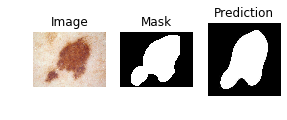

In [63]:
file_names = next(os.walk(test_data_dir))[2]
image = file_names[1]
fig = plt.figure()

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(load_img(os.path.join(test_data_dir,image)), shape = (256,256))
a.set_title('Image')
a.set_axis_off()

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(load_img(os.path.join(test_data_mask_dir,image.split('.')[0]+"_segmentation.png")), shape = (256,256))
a.set_title('Mask')
a.set_axis_off()

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(load_img(os.path.join(test_data_pred_dir,image.split('.')[0]+"_predict.jpg")), shape = (256,256))
a.set_title('Prediction')
a.set_axis_off()

In [ ]:
model.output

In [104]:
with open(result_file,"r") as f:
    data = f.readlines()
    scores = [];

    for line in data[1:]:
        result = line.split(',')
        scores.append([result[0], result[1][:-1]])

scores = np.array(scores)
sorted_scores = scores[scores[:,1].argsort()]
print('Test Jaccard Index:{}'.format(scores[:,1].astype(float).mean()))
low_scores = scores[scores[:,1].astype(float)<0.65]
low_scores = low_scores[low_scores[:,1].argsort()]
print('Total number of low prediction (jaccard index < 0.65):{}'.format(len(low_scores)) )
print('Threshold Jaccard Index:{}'.format(np.sum(scores[scores[:,1].astype(float)>0.65][:,1].astype(float)) / len(scores)))

Test Jaccard Index:0.8222325916749609
Total number of low prediction (jaccard index < 0.65):52
Threshold Jaccard Index:0.7788077731545154
